In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Self-Attention Mechanism

## Objectif
Implémenter le mécanisme d'auto-attention (self-attention), qui est le cœur des modèles Transformer.

## Formule mathématique

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

où:
- Q (Query): ce que nous cherchons
- K (Key): ce qui est disponible
- V (Value): l'information réelle
- $d_k$: dimension des clés (pour la normalisation)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 1. Génération de données d'exemple

In [5]:
# Paramètres
sequence_length = 4  # Nombre de mots dans la phrase
d_k = 8  # Dimension des clés/requêtes
d_v = 8  # Dimension des valeurs

# Génération de matrices aléatoires Q, K, V
np.random.seed(42)
Q = np.random.randn(sequence_length, d_k)
K = np.random.randn(sequence_length, d_k)
V = np.random.randn(sequence_length, d_v)

print("Query (Q) shape:", Q.shape)
print("Key (K) shape:", K.shape)
print("Value (V) shape:", V.shape)
print("\nQuery (Q):\n", Q)

Query (Q) shape: (4, 8)
Key (K) shape: (4, 8)
Value (V) shape: (4, 8)

Query (Q):
 [[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
   1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975  0.24196227 -1.91328024
  -1.72491783 -0.56228753]
 [-1.01283112  0.31424733 -0.90802408 -1.4123037   1.46564877 -0.2257763
   0.0675282  -1.42474819]
 [-0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
  -0.60170661  1.85227818]]


## 2. Calcul des scores d'attention (QK^T)

In [6]:
# Étape 1: Produit scalaire Q et K^T
attention_scores = np.matmul(Q, K.T)

print("Attention scores (avant scaling):")
print(attention_scores)
print("\nShape:", attention_scores.shape)
print(f"Variance avant scaling: {attention_scores.var():.4f}")

Attention scores (avant scaling):
[[-2.72357421  0.40818741  2.39601116 -1.18323729]
 [ 5.60012069  1.1597874  -4.7248515   2.43859568]
 [ 1.03699903 -3.70553788 -3.0399309   0.04345596]
 [ 0.09460324  2.97027193  0.43247995 -0.80026704]]

Shape: (4, 4)
Variance avant scaling: 6.8376


## 3. Scaling (Division par √d_k)

Le scaling est crucial pour éviter que les valeurs ne deviennent trop grandes, ce qui causerait des gradients très petits lors du softmax.

In [7]:
# Étape 2: Scaling par √d_k
scaled_attention_scores = attention_scores / math.sqrt(d_k)

print("Scaled attention scores:")
print(scaled_attention_scores)
print(f"\nVariance après scaling: {scaled_attention_scores.var():.4f}")

# Visualisation de l'effet du scaling
print(f"\nRéduction de variance: {attention_scores.var() / scaled_attention_scores.var():.2f}x")

Scaled attention scores:
[[-0.9629289   0.14431604  0.84711787 -0.41833756]
 [ 1.97994166  0.41004677 -1.67048727  0.86217377]
 [ 0.36663452 -1.31010548 -1.07477788  0.015364  ]
 [ 0.0334473   1.05014971  0.15290475 -0.28293713]]

Variance après scaling: 0.8547

Réduction de variance: 8.00x


## 4. Application du Softmax

In [8]:
def softmax(x):
    """Calcul du softmax de manière stable numériquement"""
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Étape 3: Application du softmax
attention_weights = softmax(scaled_attention_scores)

print("Attention weights (probabilités):")
print(attention_weights)
print("\nSomme par ligne (doit être 1.0):", attention_weights.sum(axis=1))

Attention weights (probabilités):
[[0.08431243 0.25513027 0.51521078 0.14534652]
 [0.64059204 0.1332861  0.01664257 0.2094793 ]
 [0.47006414 0.08789379 0.11121405 0.33082801]
 [0.17794451 0.49185018 0.20052305 0.12968226]]

Somme par ligne (doit être 1.0): [1. 1. 1. 1.]


## 5. Calcul de la sortie (Attention × V)

In [9]:
# Étape 4: Multiplication avec les valeurs
output = np.matmul(attention_weights, V)

print("Output shape:", output.shape)
print("\nOutput:")
print(output)

Output shape: (4, 8)

Output:
[[-0.1308104   0.77212573  0.10108921  0.16807328 -0.46588684 -0.43681263
   0.46851458 -0.42075407]
 [ 0.40109276  1.19080398 -0.35037302  0.94668908  0.08274232 -0.53010106
   0.17683369  0.41923385]
 [ 0.17910025  0.98456145 -0.06763014  0.80678092 -0.14453166 -0.49373081
   0.15002954  0.10067088]
 [ 0.01421368  1.14907671 -0.99239485  0.60451701 -0.14600018 -0.40496816
   0.24215067 -0.82777073]]


## 6. Visualisation des poids d'attention (Heatmap)

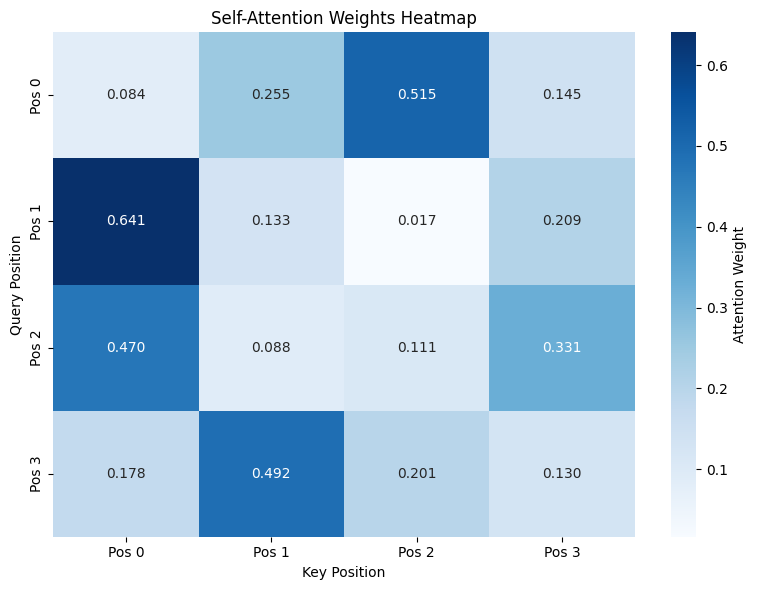


Interprétation:
- Chaque ligne montre à quelles positions le token prête attention
- Des valeurs élevées = forte attention
- La somme de chaque ligne = 1.0


In [10]:
# Visualisation de la matrice d'attention
plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=[f'Pos {i}' for i in range(sequence_length)],
            yticklabels=[f'Pos {i}' for i in range(sequence_length)],
            cbar_kws={'label': 'Attention Weight'})
plt.title('Self-Attention Weights Heatmap')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

print("\nInterprétation:")
print("- Chaque ligne montre à quelles positions le token prête attention")
print("- Des valeurs élevées = forte attention")
print("- La somme de chaque ligne = 1.0")

## 7. Fonction complète de Self-Attention

In [11]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Calcule l'attention scaled dot-product.
    
    Args:
        Q: Query matrix (seq_len, d_k)
        K: Key matrix (seq_len, d_k)
        V: Value matrix (seq_len, d_v)
        mask: Masque optionnel pour attention causale
    
    Returns:
        output: Sortie pondérée (seq_len, d_v)
        attention_weights: Poids d'attention (seq_len, seq_len)
    """
    # 1. Calcul des scores
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.T) / math.sqrt(d_k)
    
    # 2. Application du masque si fourni
    if mask is not None:
        scores = scores + mask
    
    # 3. Softmax
    attention_weights = softmax(scores)
    
    # 4. Multiplication avec V
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

# Test de la fonction
output, attention = scaled_dot_product_attention(Q, K, V)
print("Output shape:", output.shape)
print("Attention shape:", attention.shape)

Output shape: (4, 8)
Attention shape: (4, 4)


## 8. Masque causal (pour le décodeur)

Le masque causal empêche le modèle de voir les tokens futurs lors de la prédiction.

Causal mask:
[[-0.e+00 -1.e+09 -1.e+09 -1.e+09]
 [-0.e+00 -0.e+00 -1.e+09 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00]]


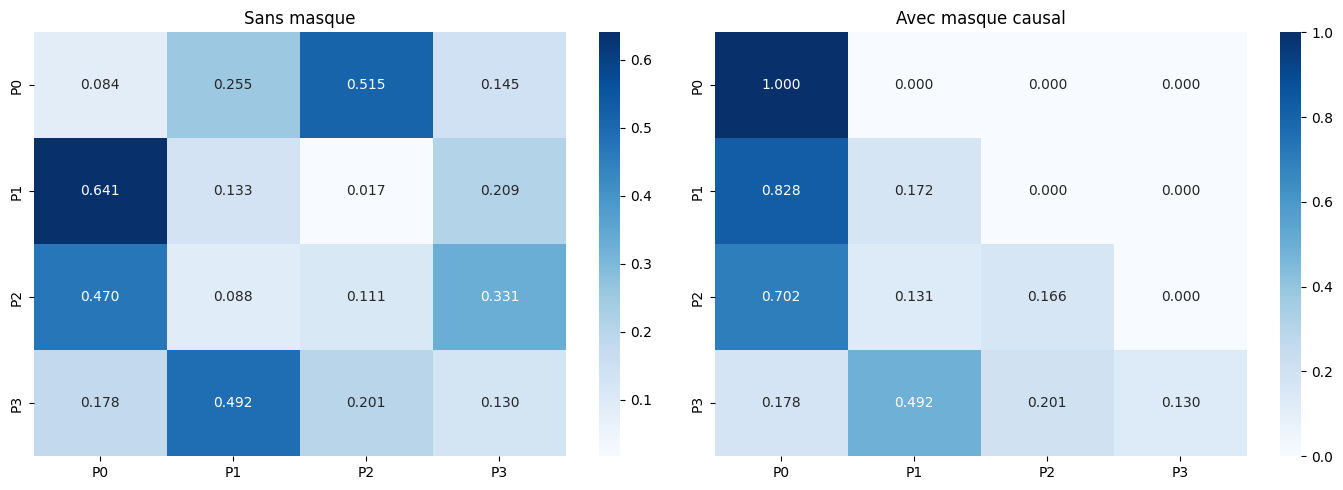


Avec le masque causal, chaque position ne peut voir que les positions précédentes!


In [12]:
# Création d'un masque causal
mask = np.triu(np.ones((sequence_length, sequence_length)), k=1) * -1e9

print("Causal mask:")
print(mask)

# Application avec masque
output_masked, attention_masked = scaled_dot_product_attention(Q, K, V, mask=mask)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(attention, annot=True, fmt='.3f', cmap='Blues', ax=axes[0],
            xticklabels=[f'P{i}' for i in range(sequence_length)],
            yticklabels=[f'P{i}' for i in range(sequence_length)])
axes[0].set_title('Sans masque')

sns.heatmap(attention_masked, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
            xticklabels=[f'P{i}' for i in range(sequence_length)],
            yticklabels=[f'P{i}' for i in range(sequence_length)])
axes[1].set_title('Avec masque causal')

plt.tight_layout()
plt.show()

print("\nAvec le masque causal, chaque position ne peut voir que les positions précédentes!")

## 9. Implémentation PyTorch

In [13]:
class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention en PyTorch"""
    
    def __init__(self):
        super().__init__()
        
    def forward(self, Q, K, V, mask=None):
        """
        Args:
            Q: (batch_size, seq_len, d_k)
            K: (batch_size, seq_len, d_k)
            V: (batch_size, seq_len, d_v)
            mask: (seq_len, seq_len) ou None
        """
        d_k = Q.size(-1)
        
        # Scores d'attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        
        # Application du masque
        if mask is not None:
            scores = scores + mask
        
        # Softmax
        attention_weights = F.softmax(scores, dim=-1)
        
        # Output
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights

# Test
attention_layer = ScaledDotProductAttention()

# Conversion en tenseurs PyTorch
Q_torch = torch.FloatTensor(Q).unsqueeze(0)  # Ajouter batch dimension
K_torch = torch.FloatTensor(K).unsqueeze(0)
V_torch = torch.FloatTensor(V).unsqueeze(0)

output_torch, attention_torch = attention_layer(Q_torch, K_torch, V_torch)

print("PyTorch output shape:", output_torch.shape)
print("PyTorch attention shape:", attention_torch.shape)
print("\nLes résultats NumPy et PyTorch sont identiques:", 
      np.allclose(output, output_torch.squeeze(0).numpy(), atol=1e-6))

PyTorch output shape: torch.Size([1, 4, 8])
PyTorch attention shape: torch.Size([1, 4, 4])

Les résultats NumPy et PyTorch sont identiques: True


## 10. Exemple concret avec des mots

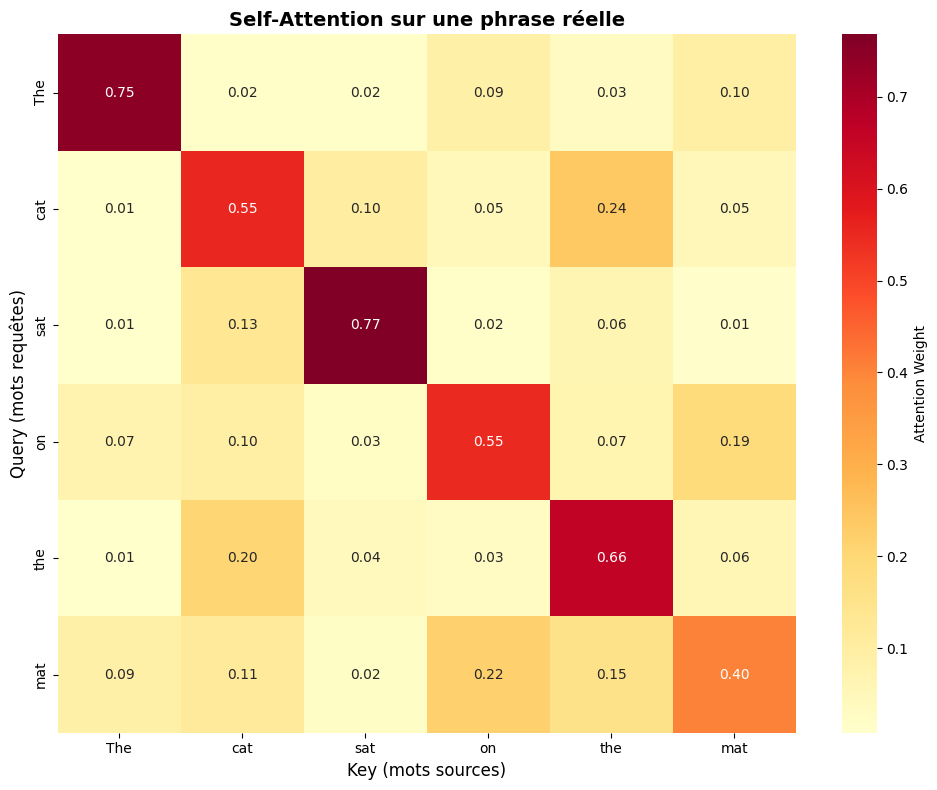


=== Analyse des poids d'attention ===
'The' prête le plus attention à 'The' (0.745)
'cat' prête le plus attention à 'cat' (0.552)
'sat' prête le plus attention à 'sat' (0.768)
'on' prête le plus attention à 'on' (0.550)
'the' prête le plus attention à 'the' (0.663)
'mat' prête le plus attention à 'mat' (0.404)


In [14]:
# Simulation avec des mots réels
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)
d_model = 8

# Création d'embeddings aléatoires pour chaque mot
np.random.seed(42)
word_embeddings = np.random.randn(seq_len, d_model)

# Calcul de l'attention
output_words, attention_words = scaled_dot_product_attention(
    word_embeddings, word_embeddings, word_embeddings
)

# Visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(attention_words, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=sentence,
            yticklabels=sentence,
            cbar_kws={'label': 'Attention Weight'})
plt.title('Self-Attention sur une phrase réelle', fontsize=14, fontweight='bold')
plt.xlabel('Key (mots sources)', fontsize=12)
plt.ylabel('Query (mots requêtes)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n=== Analyse des poids d'attention ===")
for i, word in enumerate(sentence):
    max_attention_idx = np.argmax(attention_words[i])
    max_attention_word = sentence[max_attention_idx]
    max_attention_value = attention_words[i, max_attention_idx]
    print(f"'{word}' prête le plus attention à '{max_attention_word}' ({max_attention_value:.3f})")

## Résumé et explications

### Qu'avons-nous appris?

1. **Self-Attention**: Permet à chaque mot de regarder tous les autres mots et de décider lesquels sont importants

2. **Scaling (√d_k)**: Normalise les scores pour éviter des valeurs trop grandes qui bloqueraient l'apprentissage

3. **Softmax**: Convertit les scores en probabilités (somme = 1)

4. **Masque causal**: Empêche de voir le futur (utile pour la génération de texte)

5. **Visualisation**: Les heatmaps montrent quelles relations le modèle apprend

### Points clés:
- L'attention permet au modèle de se concentrer sur les parties pertinentes de l'entrée
- C'est un mécanisme parallélisable (contrairement aux RNN)
- La complexité est O(n²) où n est la longueur de séquence